In [34]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout, Conv2D, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras import Model

def create_resnet_block(x, num_filters, block_index):
    """Creates a ResNet block with two convolutional layers and a skip connection."""
    shortcut = x
    
    # First convolution
    x = Conv2D(num_filters, (3, 3), padding='same', name=f'conv1_block{block_index}')(x)
    x = BatchNormalization(name=f'bn1_block{block_index}')(x)
    x = LeakyReLU(name=f'leaky_relu1_block{block_index}')(x)
    
    # Second convolution
    x = Conv2D(num_filters, (3, 3), padding='same', name=f'conv2_block{block_index}')(x)
    x = BatchNormalization(name=f'bn2_block{block_index}')(x)
    
    # Skip connection
    x = Add(name=f'add_block{block_index}')([x, shortcut])
    x = LeakyReLU(name=f'leaky_relu2_block{block_index}')(x)
    
    return x

def create_model_with_intermediate_outputs():
    outputs = []
    inputs = Input(shape=(96, 96, 1))
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    outputs.append(x)  # Collecting each block's output

    num_blocks = 25
    for i in range(num_blocks):
        x = create_resnet_block(x, 64, i)
        outputs.append(x)  # Collecting each block's output

    # Global average pooling and final dense layer
    x = GlobalAveragePooling2D()(x)
    final_output = Dense(4, activation='softmax')(x)
    
    # Include all intermediate outputs
    model = Model(inputs=inputs, outputs=[final_output] + outputs)
    
    return model

# Initialize the modified model
model = create_model_with_intermediate_outputs()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Found 400 images belonging to 4 classes.


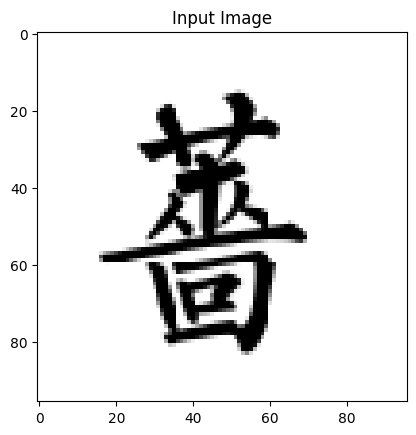

1/1 [==============================] - 1s 1s/step


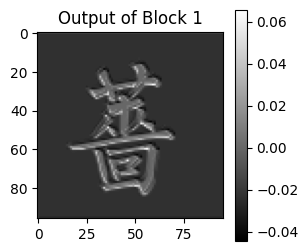

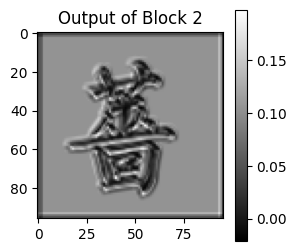

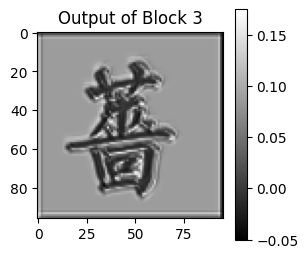

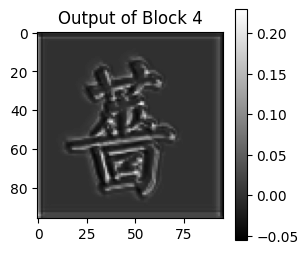

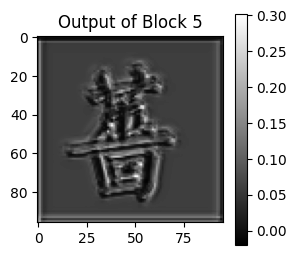

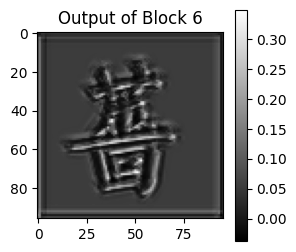

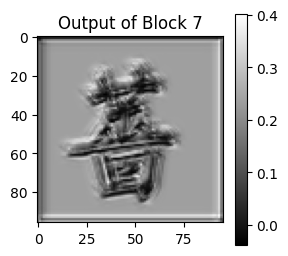

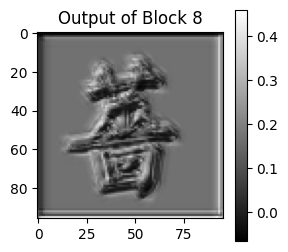

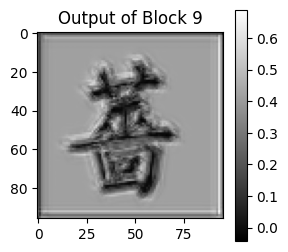

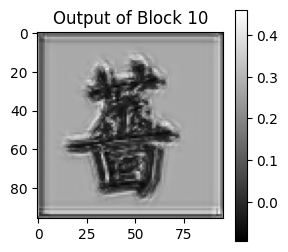

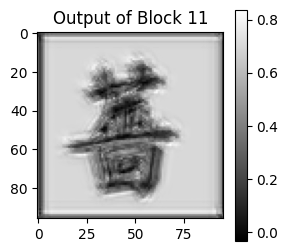

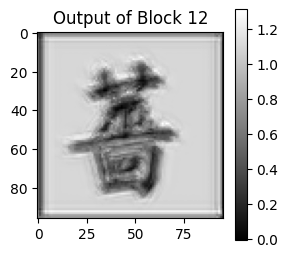

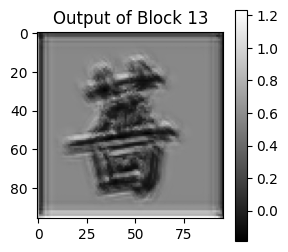

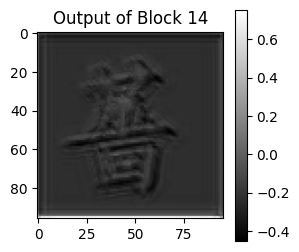

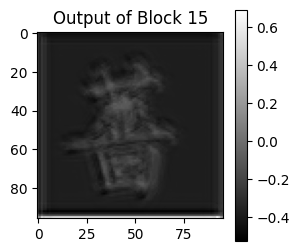

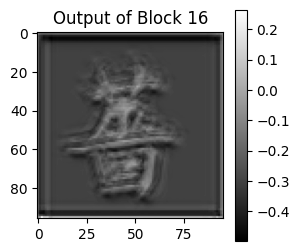

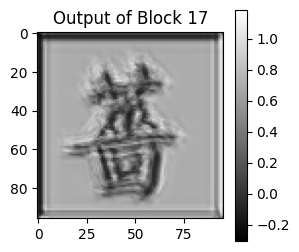

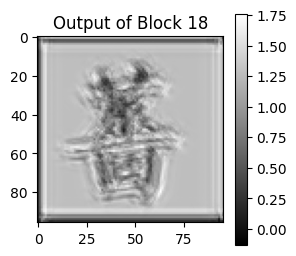

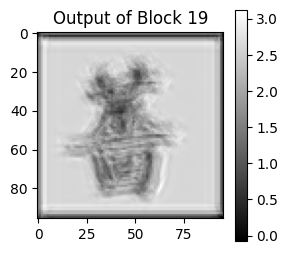

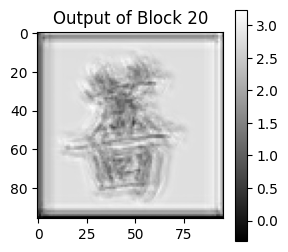

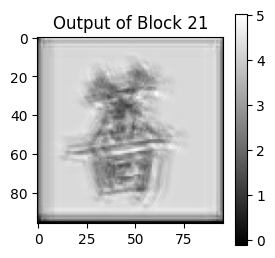

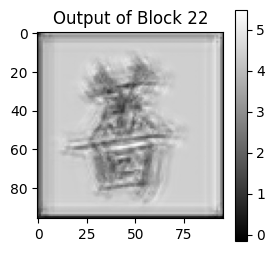

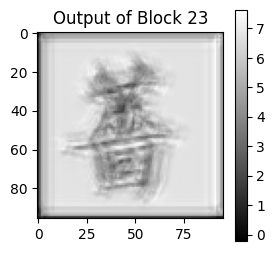

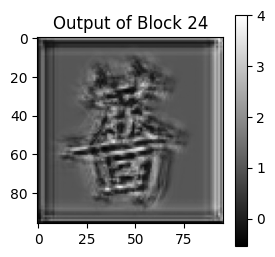

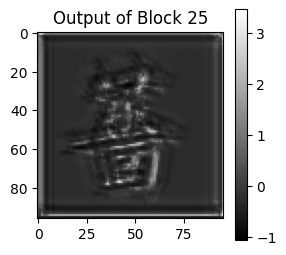

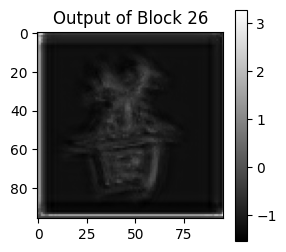

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your dataset directory
dataset_path = './images_for_visulization'

# Set up ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(rescale=1./255)  # Assuming images need to be rescaled

# Prepare the generator to read data from the directory
generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(96, 96),  # Ensure dimensions match model input
    batch_size=1,          # Process one image at a time
    color_mode='grayscale',  # 'rgb' if your model uses RGB images
    class_mode='categorical')  # Adjust based on your problem

# # Fetch one batch of data
actual_input, _ = next(generator)


plt.imshow(actual_input[0, :, :, 0], cmap='gray')
plt.title('Input Image')
plt.show()


# Predict using the model to get all outputs
outputs = model.predict(actual_input)

# Visualize the output of each block
for i, output in enumerate(outputs[1:]):  # outputs[0] is the final output
    # Adjust the indexing depending on the shape of your output
    feature_map = output[0, :, :, 0]  # Visualizing the first feature map of the output
    plt.figure(figsize=(3, 3))
    plt.imshow(feature_map, cmap='gray')  # Use 'gray' for grayscale visualization
    plt.title(f'Output of Block {i+1}')
    plt.colorbar()
    plt.show()



In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut."""
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, padding='valid', name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), padding='valid', name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, padding='valid', name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut."""
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), padding='valid', name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), padding='valid', name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x


def ResNet50(input_shape=(96, 96, 1), classes=4):
    img_input = Input(shape=input_shape)

    # First Convolution
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    outputs = [x]  # Collect the output of the first stage

    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    outputs.append(x)  # Collect the output of the second stage

    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    for i in ['b', 'c', 'd']:
        x = identity_block(x, 3, [128, 128, 512], stage=3, block=i)
    outputs.append(x)  # Collect the output of the third stage

    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    for i in ['b', 'c', 'd', 'e', 'f']:
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=i)
    outputs.append(x)  # Collect the output of the fourth stage

    # Stage 5
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    outputs.append(x)  # Collect the output of the fifth stage

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    final_output = Dense(classes, activation='softmax', name='fc' + str(classes))(x)
    outputs.append(final_output)  # Collect the final output

    model = Model(inputs=img_input, outputs=outputs, name='resnet50')
    return model

# Instantiate and compile the model
model = ResNet50(input_shape=(96, 96, 1), classes=4)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Found 400 images belonging to 4 classes.


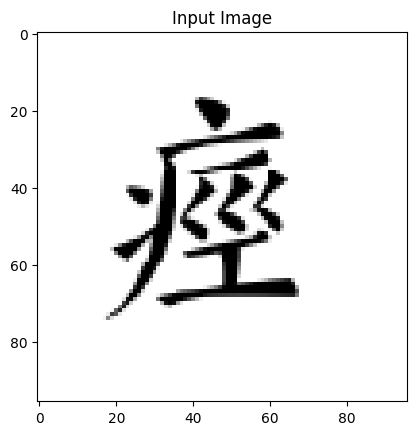

1/1 [==============================] - 0s 54ms/step
Stage 1 Output Shape: (1, 24, 24, 64)
Min: 0.0 Max: 0.42681628
Stage 2 Output Shape: (1, 24, 24, 256)
Min: 0.0 Max: 0.3554692
Stage 3 Output Shape: (1, 12, 12, 512)
Min: 0.0 Max: 0.24139674
Stage 4 Output Shape: (1, 6, 6, 1024)
Min: 0.0 Max: 0.22127499
Stage 5 Output Shape: (1, 3, 3, 2048)
Min: 0.0 Max: 0.16378948
Stage 6 Output Shape: (1, 4)
Min: 0.241316 Max: 0.2556275


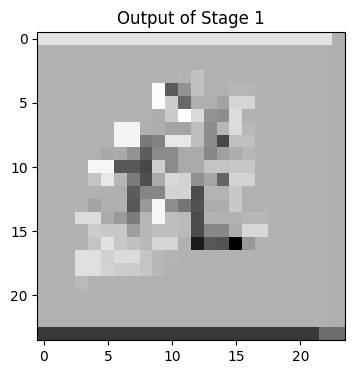

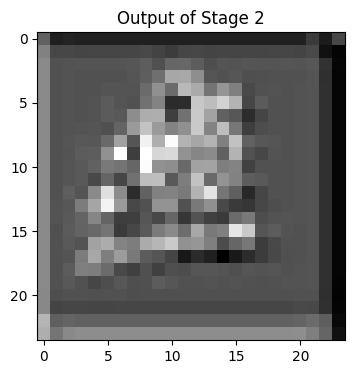

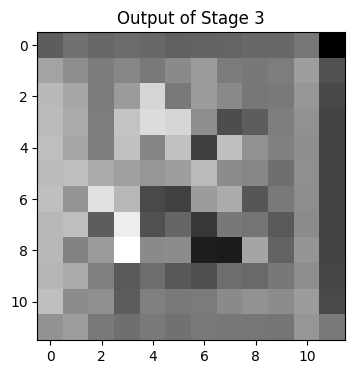

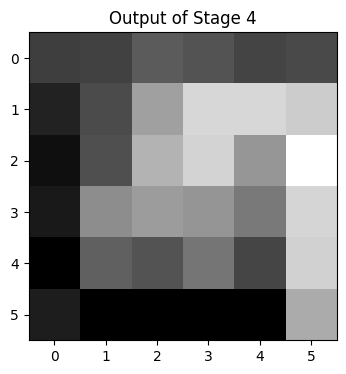

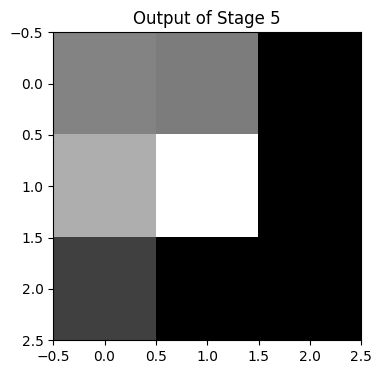

<Figure size 400x400 with 0 Axes>

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define the path to your dataset directory
dataset_path = './images_for_visulization'

# Set up ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(rescale=1./255)  # Assuming images need to be rescaled

# Prepare the generator to read data from the directory
generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(96, 96),  # Ensure dimensions match model input
    batch_size=1,          # Process one image at a time
    color_mode='grayscale',  # 'rgb' if your model uses RGB images
    class_mode='categorical')  # Adjust based on your problem

# # Fetch one batch of data
stage_input, _ = next(generator)

plt.imshow(stage_input[0, :, :, 0], cmap='gray')
plt.title('Input Image')
plt.show()


# Get outputs for all stages
stage_outputs = model.predict(stage_input)

for i, output in enumerate(stage_outputs):
    print(f'Stage {i+1} Output Shape:', output.shape)
    print('Min:', np.min(output), 'Max:', np.max(output))




for i, output in enumerate(stage_outputs):
    plt.figure(figsize=(4, 4))
    if len(output.shape) == 4:
        plt.imshow(output[0, :, :, 0], cmap='gray', interpolation='nearest')  # Use 'gray' for grayscale visualization
        plt.title(f'Output of Stage {i+1}')
    # plt.colorbar()
    plt.show()




In [27]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dropout, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model

def create_model():
    inputs = Input(shape=(96, 96, 1))
    x = inputs
    
    outputs = []  # List to collect outputs of each convolutional block for visualization

    # First convolutional block
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    outputs.append(x)  # Append output after the first block

    # Repeat for additional blocks
    for i in range(3):
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        outputs.append(x)

        # Repeat for additional blocks
    for i in range(12):
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        outputs.append(x)

    # Introduce skip connections and additional blocks
    skip1 = x
    for _ in range(5):
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
    x = Add()([x, skip1])
    outputs.append(x)  # After skip connection

    skip2 = x
    for _ in range(5):
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
    x = Add()([x, skip2])
    outputs.append(x)  # After second skip connection

    # Final layers
    x = GlobalAveragePooling2D()(x)
    final_output = Dense(4, activation='softmax')(x)
    outputs.append(final_output)  # Final output

    # Creating the model object with inputs and all collected outputs
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Found 400 images belonging to 4 classes.


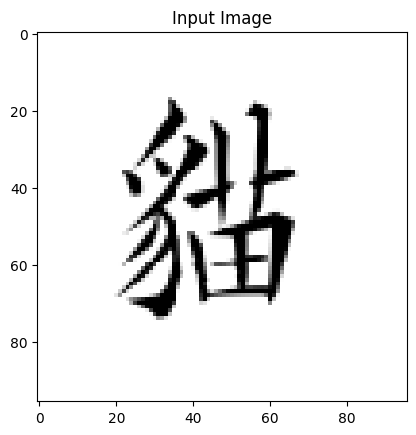

1/1 [==============================] - 0s 29ms/step


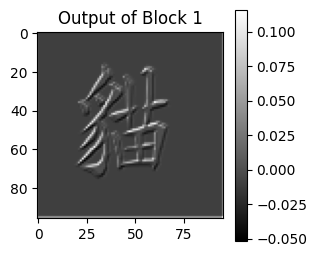

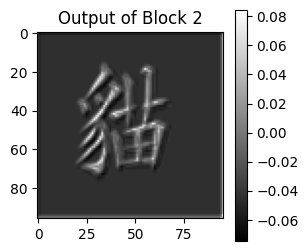

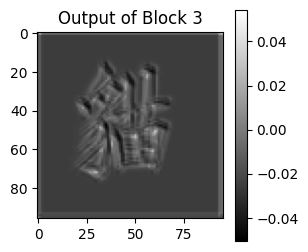

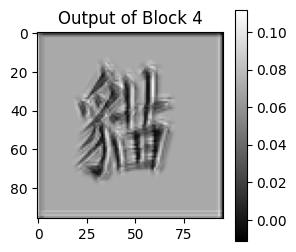

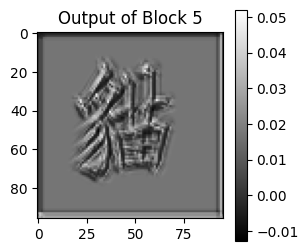

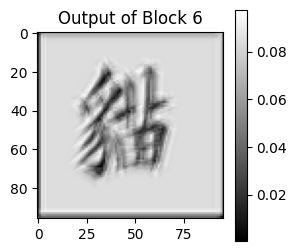

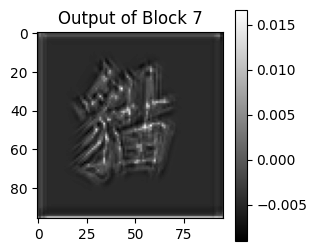

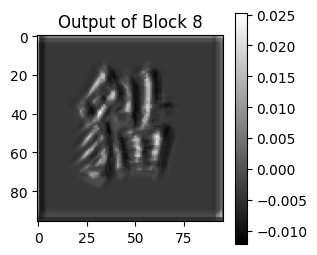

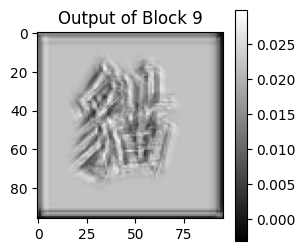

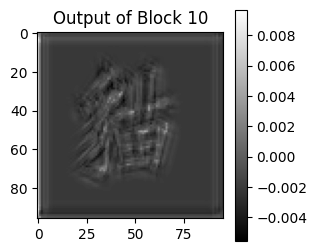

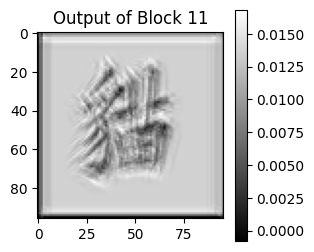

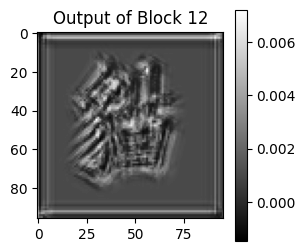

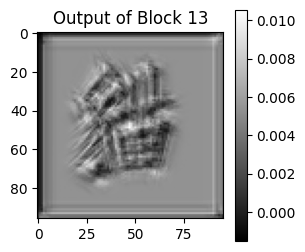

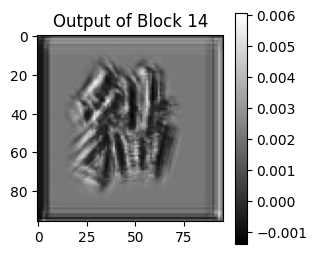

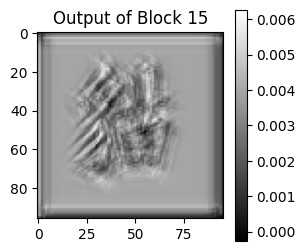

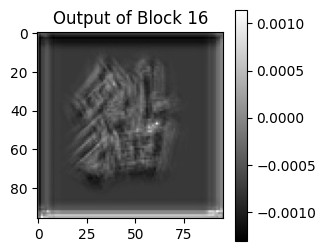

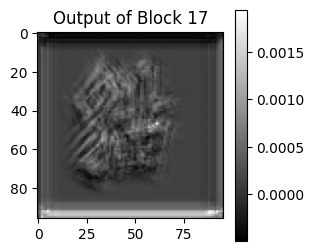

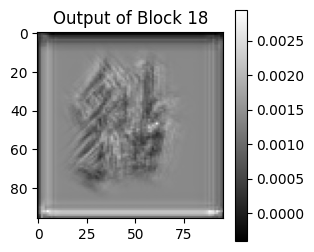

In [30]:
# Define the path to your dataset directory
dataset_path = './images_for_visulization'

# Set up ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(rescale=1./255)  # Assuming images need to be rescaled

# Prepare the generator to read data from the directory
generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(96, 96),  # Ensure dimensions match model input
    batch_size=1,          # Process one image at a time
    color_mode='grayscale',  # 'rgb' if your model uses RGB images
    class_mode='categorical')  # Adjust based on your problem

# # Fetch one batch of data
data_input, _ = next(generator)

plt.imshow(data_input[0, :, :, 0], cmap='gray')
plt.title('Input Image')
plt.show()

# Predict with the model to get all intermediate outputs
data_outputs = model.predict(data_input)

# Visualize each output
for i, output in enumerate(data_outputs):
    if len(output.shape) == 4:  # This checks if the output is a feature map
        plt.figure(figsize=(3, 3))
        feature_map = output[0, :, :, 0]  # Take the first feature map from the first output
        plt.imshow(feature_map, cmap='gray')  # Use 'gray' for grayscale visualization
        plt.title(f'Output of Block {i + 1}')
        plt.colorbar()
        plt.show()

